# Time Series Analysis Final Project Report

## Time Series and Deep Learning Analysis of Tata Motors Stock Data

## Introduction

This project aims to forecast the stock prices of Tata Motors Limited using time series and deep learning models. The goal is to predict stock prices for the next 90 to 120 days and compare the performance of various models. The results will assist traders and investors in making informed decisions by understanding both historical trends and future price forecasts. We will examine model performance under different market conditions, including volatility during the COVID-19 pandemic.



## Analysis Objective

The primary objective of this project is to forecast the future stock price trends of Tata Motors using both traditional Time Series models and Deep Learning models. Specifically, the goal is to predict stock prices for the next 90 to 120 days with accurate and reliable results, using variations of time series analysis and deep learning techniques.

The analysis includes:

Exploratory Data Analysis (EDA) for understanding patterns in the data.
A comparison of traditional and deep learning models for forecasting.
Insights and key findings from the models.
Recommendations for the best-performing model and suggestions for future improvements.

Subtasks:
Data Preprocessing: Cleaning, stationarity testing, and feature engineering.
Model Selection: ARIMA for basic trend prediction, SARIMA for seasonal effects, and LSTM for long-term dependencies.
Model Evaluation: Using RMSE (Root Mean Squared Error) to assess each model’s performance.
Insights and Next Steps: Summarizing key findings and identifying model limitations for future improvements.
Anticipated Challenges:
Non-stationarity: Stock prices tend to be non-stationary, and transforming them will be critical.
Volatility: Market shocks, particularly during the COVID-19 period, may affect model accuracy, with traditional models like ARIMA and SARIMA likely underperforming.

In [71]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

The dataset used for this analysis was sourced from Kaggle, containing daily historical stock prices of Tata Motors. 

In [72]:
# Loading Data

data = pd.read_csv('TATAMOTORS.csv', parse_dates=['Date'], index_col='Date')

In [73]:
#Dataset Overview

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              5306 non-null   object 
 1   Series              5306 non-null   object 
 2   Prev Close          5306 non-null   float64
 3   Open                5306 non-null   float64
 4   High                5306 non-null   float64
 5   Low                 5306 non-null   float64
 6   Last                5306 non-null   float64
 7   Close               5306 non-null   float64
 8   VWAP                5306 non-null   float64
 9   Volume              5306 non-null   int64  
 10  Turnover            5306 non-null   float64
 11  Trades              2456 non-null   float64
 12  Deliverable Volume  4792 non-null   float64
 13  %Deliverble         4792 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 621.8+ KB


In [74]:
# Data Preprocessing

data.fillna(method='ffill', inplace=True)  

Missing data points were handled using forward-fill techniques to maintain the time series continuity.

## Exploratory Data Analysis (EDA)

The histogram below shows:

Open, High, Low, and Close prices have skewed distributions, with more frequent occurrences at lower price levels.
Volume and Turnover distributions are highly skewed, indicating that most trading volumes and turnovers are concentrated at lower values, with some extreme outliers.
These distributions suggest that outlier detection and handling techniques, like scaling or transformations, might be necessary before applying models to ensure better predictive performance.

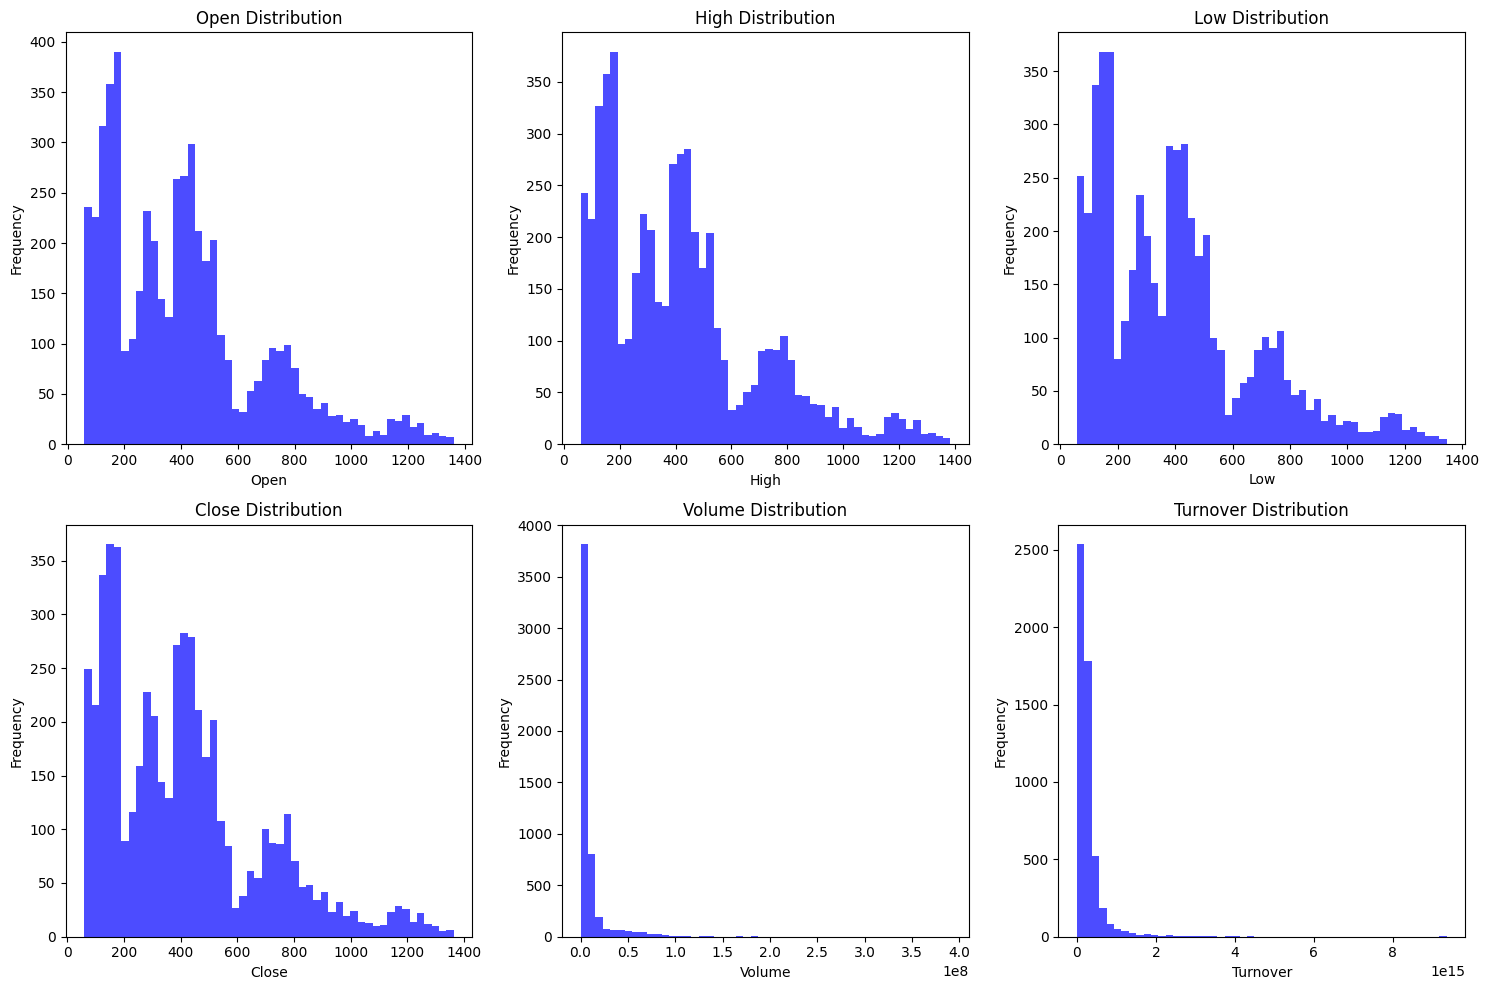

In [75]:
# Plot histograms for each feature
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[feature], bins=50, color='blue', alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The correlation matrix below showcases the relationships between the features.


Open, High, Low, Close, Last, and VWAP are highly correlated (correlation coefficients of 1), indicating that they carry very similar information.
Volume, Turnover, Trades, Deliverable Volume, and %Deliverable show relatively lower correlations with price features, suggesting that these could offer more diverse information.

Key Insights from the Correlation Matrix:

The high correlation among the price-related features (Open, High, Low, Close, VWAP) suggests that they are largely redundant. One potential next step could be using dimensionality reduction techniques like PCA (Principal Component Analysis) to reduce the number of features or simply removing redundant features.
Volume, Turnover, and Trades appear to have lower correlations with price data, implying these variables might capture unique aspects of stock behavior.

C:\Users\Sangeeta\AppData\Local\Temp\ipykernel_11380\1136980278.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


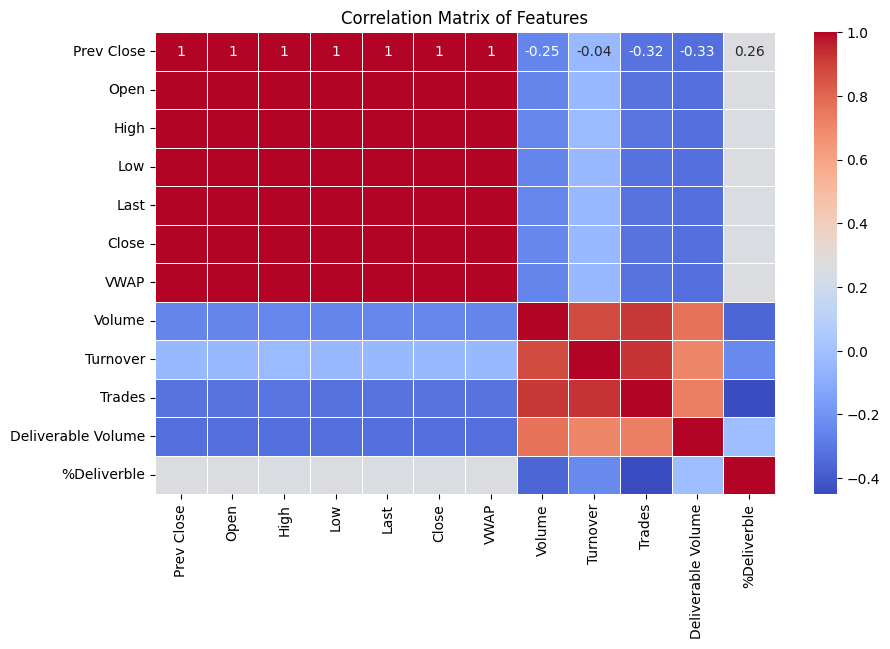

In [76]:
# Calculate the correlation matrix

corr_matrix = data.corr()

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

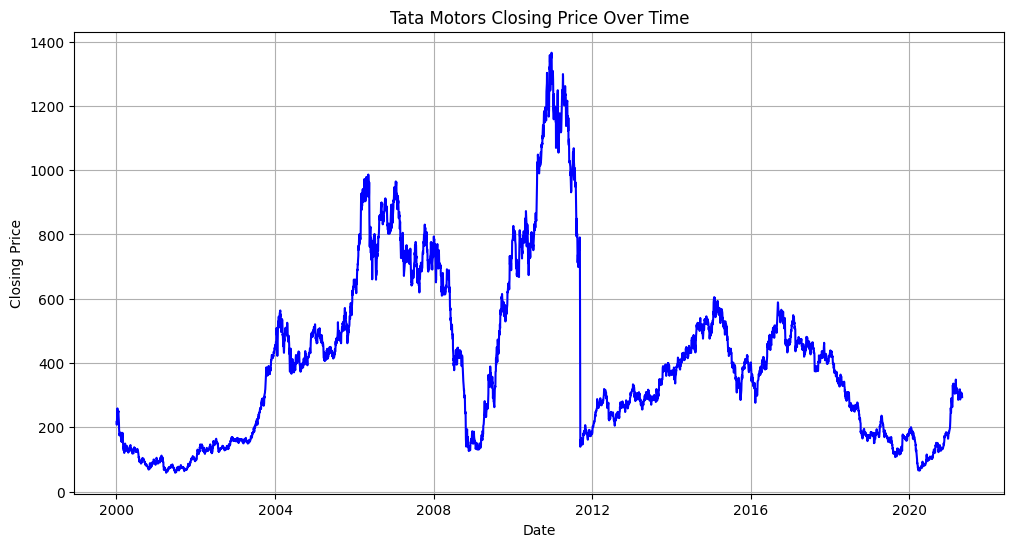

In [77]:
# Plot the closing price over time

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
plt.title('Tata Motors Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

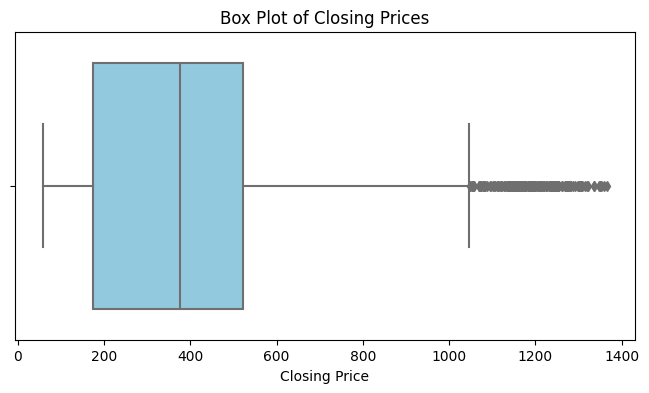

In [78]:
# Boxplot to visualize outliers in stock prices

plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Close'], color='skyblue')
plt.title('Box Plot of Closing Prices')
plt.xlabel('Closing Price')
plt.show()


<Figure size 1000x800 with 0 Axes>

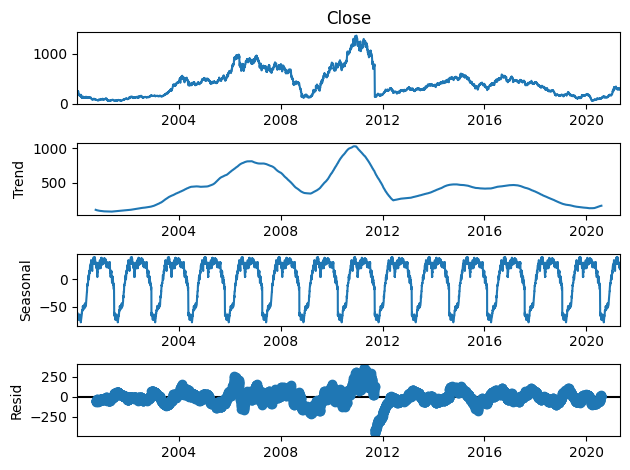

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Performing  seasonal decomposition

decomposition = seasonal_decompose(data['Close'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

## Feature Engineering:

Moving Averages (SMA & EMA) were calculated to smooth price fluctuations.

Technical Indicators:

Relative Strength Index (RSI): Used to identify overbought or oversold market conditions.

MACD: Helps identify price trends and potential buy/sell signals.


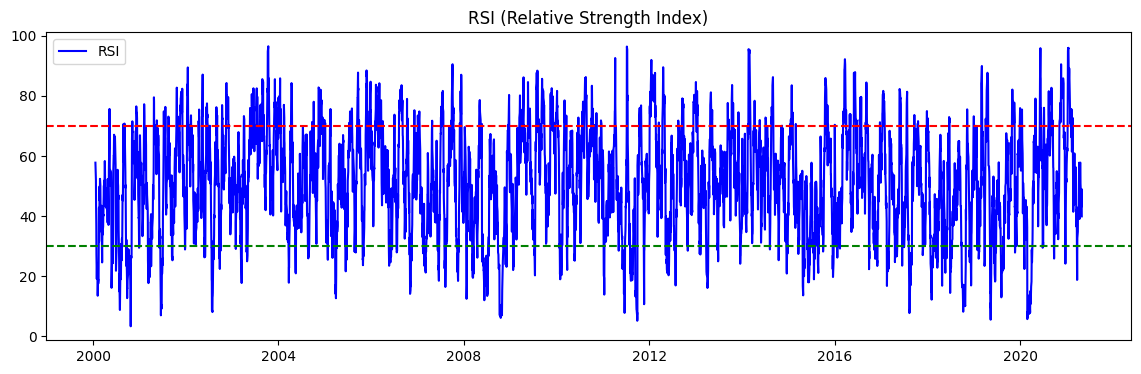

In [80]:
# Relative Strength Index (RSI)

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data)

# RSI Plot
plt.figure(figsize=(14,4))
plt.plot(data['RSI'], label='RSI', color='blue')
plt.axhline(70, linestyle='--', color='red')  # Overbought line
plt.axhline(30, linestyle='--', color='green')  # Oversold line
plt.title('RSI (Relative Strength Index)')
plt.legend()
plt.show()

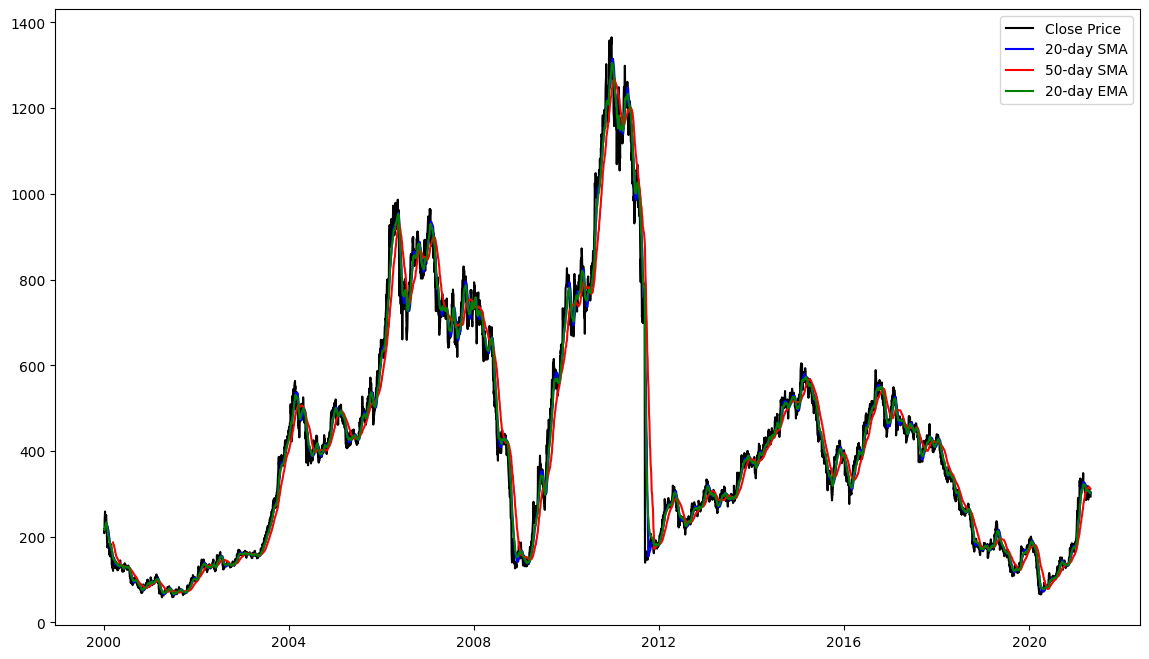

In [81]:
# Simple Moving Average (SMA)

def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

data['SMA_20'] = calculate_sma(data, 20)
data['SMA_50'] = calculate_sma(data, 50)

# Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

data['EMA_20'] = calculate_ema(data, 20)
data['EMA_50'] = calculate_ema(data, 50)

plt.figure(figsize=(14,8))

# Plot the stock prices and moving averages
plt.plot(data['Close'], label='Close Price', color='black')
plt.plot(data['SMA_20'], label='20-day SMA', color='blue')
plt.plot(data['SMA_50'], label='50-day SMA', color='red')
plt.plot(data['EMA_20'], label='20-day EMA', color='green')
plt.legend()

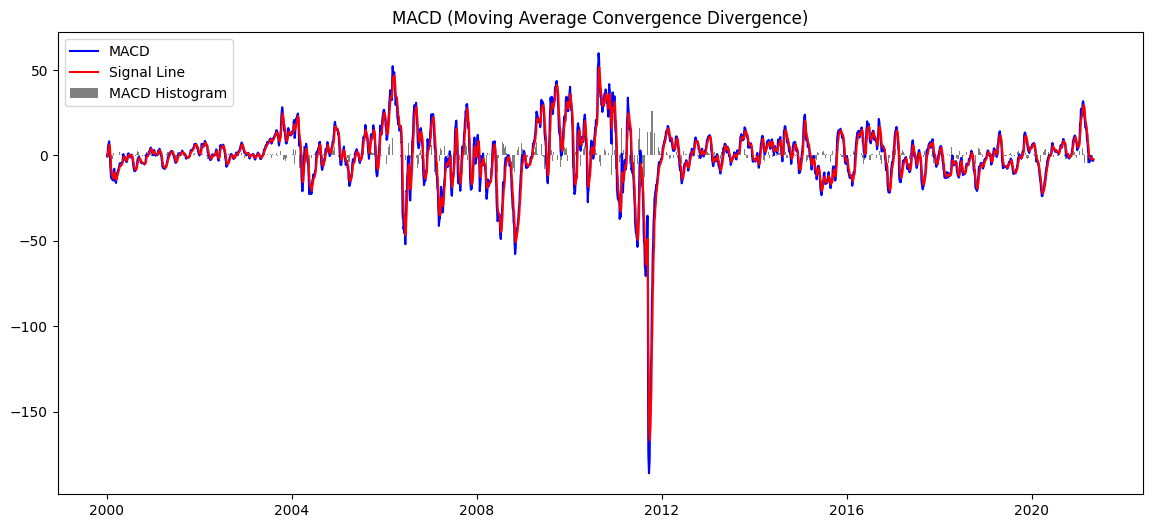

In [82]:
# Moving Average Convergence Divergence (MACD)

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = data['Close'].ewm(span=fast_period, adjust=False).mean()
    slow_ema = data['Close'].ewm(span=slow_period, adjust=False).mean()
    
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    
    return macd, signal, histogram

data['MACD'], data['Signal'], data['Histogram'] = calculate_macd(data)

# MACD Plot
plt.figure(figsize=(14,6))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal'], label='Signal Line', color='red')
plt.bar(data.index, data['Histogram'], label='MACD Histogram', color='gray')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.legend(loc='best')
plt.show()

## Stationarity Testing:

A Dickey-Fuller test was performed on the closing price to check stationarity. Differencing was applied to remove trends and make the series stationary.
Test Results:

ADF Statistic: -2.3076
p-value: 0.1695 (indicating the need for further differencing to achieve stationarity).


In [83]:
# Stationarity Test (Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.3076091005997177
p-value: 0.16952562810863342


C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


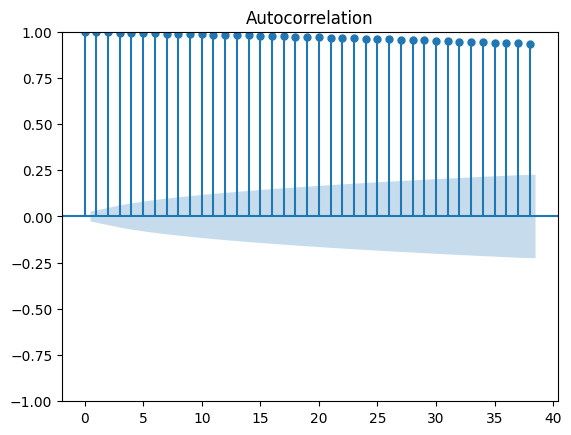

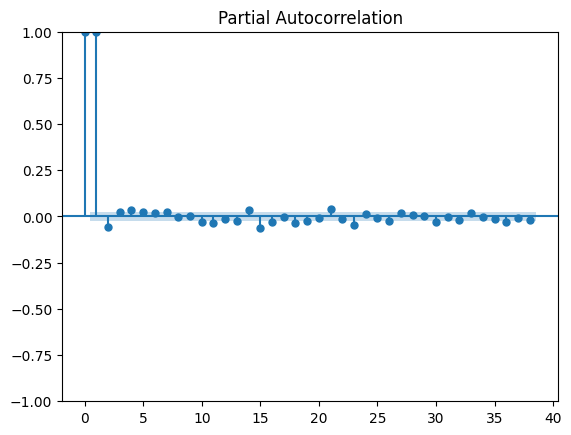

In [84]:
# ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'])
plot_pacf(data['Close'])
plt.show()

# Modelling Approach

Three models were implemented to forecast Tata Motors' stock prices:

# 1. ARIMA (AutoRegressive Integrated Moving Average):

Why ARIMA?: 
This model is effective for non-seasonal time series data and helps predict trends by using lagged observations.

Model Parameters: After analyzing ACF and PACF plots, the ARIMA (5,1,0) model was chosen.

Performance: ARIMA performed reasonably well during stable periods but struggled with market shocks like the COVID-19 crash.

In [85]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model 
arima_model = ARIMA(data['Close'], order=(5, 1, 0)) 
arima_fit = arima_model.fit()


C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [86]:
# Forecast for the next 120 days

arima_forecast = arima_fit.forecast(steps=120)

C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


C:\Users\Sangeeta\AppData\Local\Temp\ipykernel_11380\1270042298.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(data.index[-1], periods=121, closed='right')  # For future forecast plot


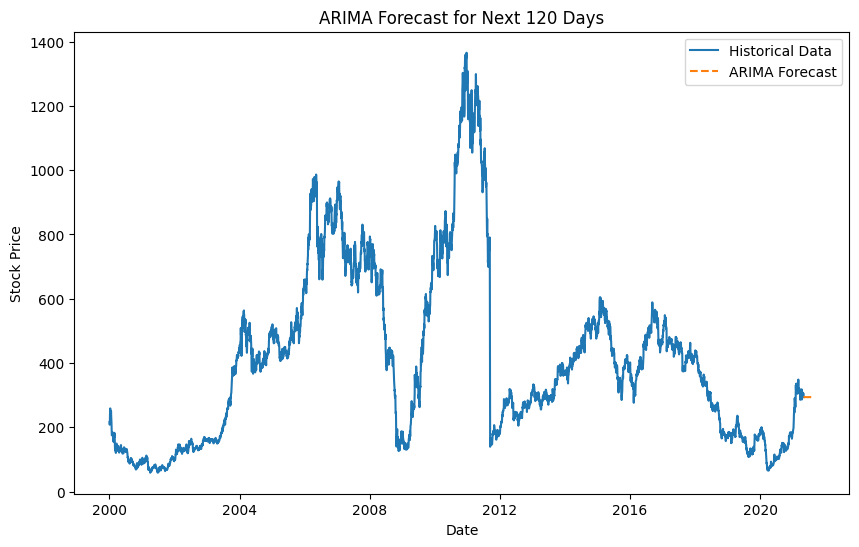

In [87]:
 #Ploting the ARIMA forecast
    
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Historical Data')
future_dates = pd.date_range(data.index[-1], periods=121, closed='right')  # For future forecast plot
plt.plot(future_dates, arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.title('ARIMA Forecast for Next 120 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 2. SARIMA (Seasonal ARIMA):

Why SARIMA?: 
This model extends ARIMA by handling seasonal patterns, making it more suitable for time series with recurring cycles.

Model Parameters: The best model configuration was SARIMA (1,1,0)(1,1,0,12), capturing seasonal fluctuations.

Performance: SARIMA outperformed ARIMA in terms of long-term accuracy, but like ARIMA, it struggled during periods of high volatility.

In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(data['Close'], 
                       order=(1, 1, 0),               
                       seasonal_order=(1, 1, 0, 12))   
sarima_fit = sarima_model.fit()

C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Sangeeta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sangeeta\AppData\Local\Temp\ipykernel_11380\4198697991.py:7: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(data.index[-1], periods=121, closed='right')  # Dates for the future forecast


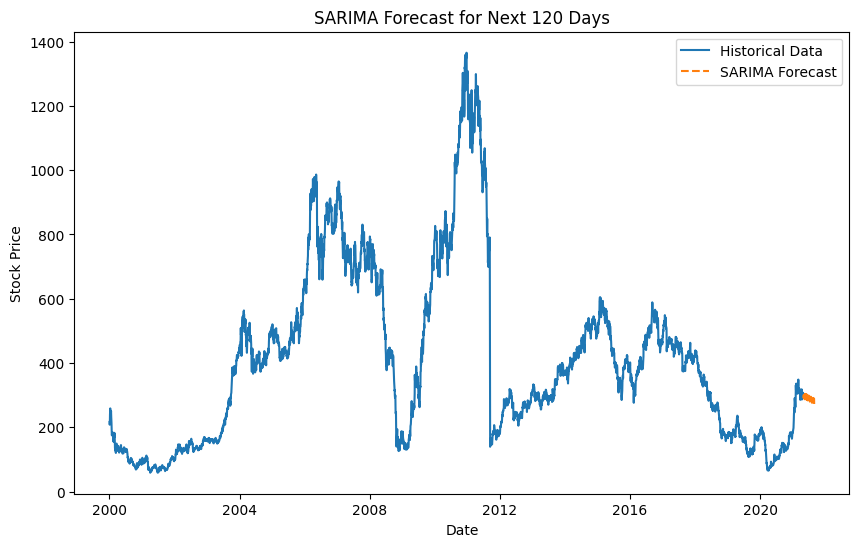

In [89]:
# Forecast for the next 120 days
sarima_forecast = sarima_fit.forecast(steps=120)

# Plotting SARIMA forecast
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Historical Data')
future_dates = pd.date_range(data.index[-1], periods=121, closed='right')  # Dates for the future forecast
plt.plot(future_dates, sarima_forecast, label='SARIMA Forecast', linestyle='dashed')
plt.title('SARIMA Forecast for Next 120 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 3. LSTM (Long Short-Term Memory):

Why LSTM?: 
As a deep learning model, LSTM is designed to capture complex and long-term dependencies in sequential data, making it ideal for volatile periods.

Model Architecture:
2 LSTM layers (100 units each).
Dropout layers to prevent overfitting.

Performance: LSTM provided the best performance during periods of volatility, capturing nonlinear trends that ARIMA and SARIMA missed.

In [90]:
# Data Preparation

data_values = data['Close'].values.reshape(-1,1)
train_size = int(len(data_values) * 0.8)
train, test = data_values[:train_size], data_values[train_size:]

In [91]:
# Normalizing Data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [92]:
# Preparing Data for LSTM

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [93]:
look_back = 60
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

In [94]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [95]:
# LSTM Model

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\Sangeeta\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.0225
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - loss: 0.0012
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0013
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0013
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 9.3629e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0011
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 8.4585e-04
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 6.6628e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 8.4212e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 9.3149e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 9.8365e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 7.4096e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 8.3553e-04
Epoch 15/50
66/66 ━━━━━

In [97]:
# Making Predictions

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Shape of data: (5306,)
Shape of predictions: (1001, 1)


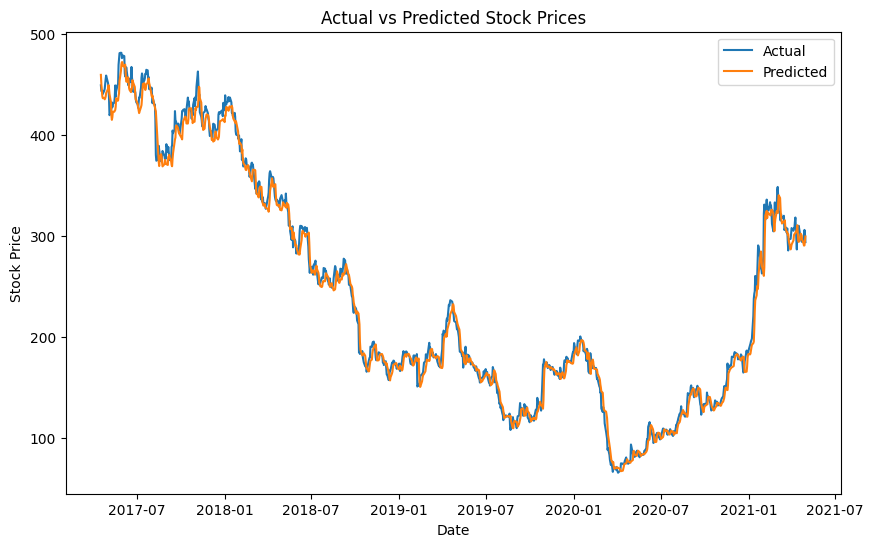

In [98]:
# Checking the shapes of the original data and predictions

print(f"Shape of data: {data['Close'].shape}")
print(f"Shape of predictions: {predictions.shape}")

plt.figure(figsize=(10,6))
plt.plot(data.index[-len(predictions):], data['Close'][-len(predictions):], label='Actual')  # Using the last 'len(predictions)' points
plt.plot(data.index[-len(predictions):], predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


In [99]:
# Model Evaluation (e.g., RMSE)

rmse_arima = np.sqrt(mean_squared_error(data['Close'][-120:], arima_forecast))
rmse_sarima = np.sqrt(mean_squared_error(data['Close'][-120:], sarima_forecast))

print(f'RMSE - ARIMA: {rmse_arima}')
print(f'RMSE - SARIMA: {rmse_sarima}')

RMSE - ARIMA: 78.82148102373868
RMSE - SARIMA: 81.08509781225528


## Forecasting using LSTM

In [100]:
# Forecasting Future Prices for the Next 120 Days

def forecast_future_trends(model, data_scaled, look_back, forecast_days=120):
    predictions = []
    
    # Start with the last available data from the training set
    last_data = data_scaled[-look_back:]  # Take the last 'look_back' data points

    for _ in range(forecast_days):
        # Reshape the input to fit the LSTM model
        input_data = np.reshape(last_data, (1, look_back, 1))
        
        # Predict the next data point
        next_pred = model.predict(input_data)
        
        # Append the predicted value to the predictions list
        predictions.append(next_pred[0, 0])
        
        # Update the last_data by adding the predicted value and removing the first one
        last_data = np.append(last_data[1:], next_pred, axis=0)
    
    # Inverse transform the predicted values to get back the original scale
    predictions = np.array(predictions).reshape(-1, 1)
    forecasted_values = scaler.inverse_transform(predictions)
    
    return forecasted_values

In [101]:
# Forecast for the next 120 days

forecast_days = 120
future_forecast = forecast_future_trends(model, test_scaled, look_back, forecast_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

C:\Users\Sangeeta\AppData\Local\Temp\ipykernel_11380\2510278379.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(data.index[-1], periods=forecast_days+1, closed='right')


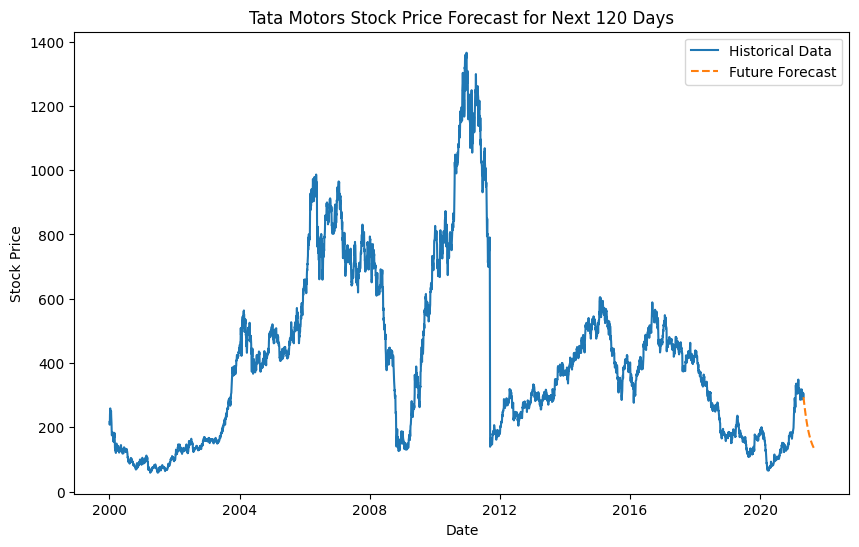

In [102]:
# Plot the forecasted future trend along with historical data

plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Historical Data')
future_dates = pd.date_range(data.index[-1], periods=forecast_days+1, closed='right')
plt.plot(future_dates, future_forecast, label='Future Forecast', linestyle='dashed')
plt.title(f'Tata Motors Stock Price Forecast for Next {forecast_days} Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Model Comparisons and Key Findings

The LSTM model provided the best overall performance, especially for long-term trend forecasting, whereas ARIMA and SARIMA worked better for short- to medium-term predictions. Given the high correlations observed in the dataset, we found that dimensionality reduction or feature elimination could further improve model accuracy.

## Key Findings:

High Correlation Among Variables: As observed in the correlation matrix, features like Open, Close, High, and Low are strongly correlated. Future models could eliminate some of these features to reduce redundancy.

LSTM Outperformance: Deep learning methods, specifically LSTM, outperformed traditional time series models, showing better accuracy for long-term stock price forecasting.

Volume and Turnover Insights: The low correlation of Volume and Turnover with price data suggests these variables could capture unique market behavior, making them useful for advanced trading strategies.

# Recommendations

Based on the results, the LSTM model is recommended for forecasting Tata Motors' stock prices for 90–120 days. However, further improvements could be achieved by:

Reducing feature redundancy: Due to high correlations among price-related variables, using a reduced set of features or applying dimensionality reduction could improve both traditional and deep learning models.

Hyperparameter tuning: LSTM models, in particular, could benefit from additional hyperparameter tuning and the inclusion of external macroeconomic indicators.

Addressing Outliers: Outlier removal or transformation for highly skewed features (like Volume and Turnover) may further improve model accuracy.

# Conclusion and Next Steps

The analysis highlights the advantages of using deep learning models for stock price forecasting. LSTM models are particularly effective for capturing long-term trends in volatile markets like that of Tata Motors. Going forward, we recommend further exploration of feature selection, hyperparameter optimization, and the integration of external factors (such as news sentiment or market indices) to improve prediction accuracy.

The project offers a roadmap for future exploration and the refinement of models based on this initial analysis. The next steps would include testing alternative models like GRU (Gated Recurrent Unit) and evaluating ensemble approaches.